# Visible Light Spectrum

![Visible Light](https://smd-cms.nasa.gov/wp-content/uploads/2023/04/visible_wave-jpg.webp)  

#### Source: NASA

In [80]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")

In [81]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import time

### Audio Processing Functions

In [82]:
def get_wave(frequency, duration = 0.5, amplitude=AMPLITUDE):
    t = np.linspace(0, duration, int(SAMPLE_RATE*duration))
    wave = amplitude * np.sin(2* np.pi* frequency* t) # A sin(2*pi*f*t)
    return wave

In [83]:
def get_piano_notes():
    octave = ["C", "c", "D", "d", "E", "F", "f", "G", "g", "A", "a", "B"]
    base_frequency = 32.70320 # C1 - lowest C of the piano
    
    # note_freq = base_frequency * 2^(n/12)
    # For example, if we consider C (n=0) as our base note, then C# will have the frequency = base_freq * 2^(1/12)
    note_frequencies = {}
    
    note_frequencies["A0"] = 27.5 * pow(2, 0/12)
    note_frequencies["a0"] = 27.5 * pow(2, 1/12)
    note_frequencies["B0"] = 27.5 * pow(2, 2/12)
    
    i = 0
    for k in range(1,9):
        for j in range(len(octave)):
            note_frequencies[octave[j] + str(k)] = base_frequency * pow(2, i/12)
                
            if(octave[j] == "C" and k == 8):
                break
            i += 1
    
    note_frequencies[''] = 0.0 # silence
    return note_frequencies

print("Min/ Max Piano: ", get_piano_notes()["A0"], get_piano_notes()["C8"])
print("Min/ Max Violin: ", get_piano_notes()["G3"], get_piano_notes()["E7"])
print("Min/ Max Viola: ", get_piano_notes()["C3"], get_piano_notes()["C6"])
print("Min/ Max Cello: ", get_piano_notes()["C2"], get_piano_notes()["E5"])

Min/ Max Piano:  27.5 4186.0096
Min/ Max Violin:  195.99774398605402 2637.0208050510087
Min/ Max Viola:  130.8128 1046.5024
Min/ Max Cello:  65.4064 659.2552012627522


In [84]:
piano = get_piano_notes()
violin = {}
viola = {}
cello = {}

pianoList = list(get_piano_notes())

minViolin = pianoList.index("G3")
maxViolin = pianoList.index("E7")+1
minViola = pianoList.index("C3")
maxViola = pianoList.index("C6")+1
minCello = pianoList.index("C2")
maxCello = pianoList.index("E5")+1

for i in range(minViolin, maxViolin):
    violin[pianoList[i]] = get_piano_notes()[pianoList[i]]
    
for i in range(minViola, maxViola):
    viola[pianoList[i]] = get_piano_notes()[pianoList[i]]
    
for i in range(minCello, maxCello):
    cello[pianoList[i]] = get_piano_notes()[pianoList[i]]

# Converting Flyover Videos to Sound

In [85]:
# Open the Video
video_path = "flyover3.mp4"
capture = cv2.VideoCapture(video_path)
print(capture.isOpened())

True


In [86]:
N_FRAMES = capture.get(cv2.CAP_PROP_FRAME_COUNT)
FPS = capture.get(cv2.CAP_PROP_FPS)
VIDEO_LENGTH = N_FRAMES/ FPS

print("No of Frames: ", N_FRAMES)
print("FPS: ",FPS)
print("Length: ", VIDEO_LENGTH)

No of Frames:  1799.0
FPS:  29.97002997002997
Length:  60.026633333333336


In [87]:
# RGB and HSV values are extracted

yBlue = []
yGreen = []
yRed = []

H = []
S = []
V = []

start = time.time()

while not capture.isOpened():
    capture = cv2.VideoCapture(video_path)

pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
attempts = 0
current = pointerFrame

while True:
    flag, frame = capture.read()
    
    if flag:
        # Frame is ready and already captured
        
        # BGR Readings =====================================
        yBlue.append(frame[:, :, 0])
        yGreen.append(frame[:, :, 1])
        yRed.append(frame[:, :, 2])
        # ==================================================
        
        # HSV Readings =====================================
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        H.append(hsv[:, :, 0])
        S.append(hsv[:, :, 1])
        V.append(hsv[:, :, 2])
        # ==================================================
        
        # print(pointerFrame)
        current = pointerFrame
        pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
        
    else:
        # Frame is not ready
        
        if(current == pointerFrame and attempts > 10):
            attempts = 0
            break
        else:           
            #print("Not Ready")
            attempts += 1
            capture.set(cv2.CAP_PROP_POS_FRAMES, pointerFrame - 1)      
        
    if N_FRAMES == cv2.CAP_PROP_POS_FRAMES:
        break
        
if (int(N_FRAMES) < len(yBlue)):
    yBlue = yBlue[0: int(N_FRAMES)]
    yGreen = yGreen[0: int(N_FRAMES)]
    yRed = yRed[0: int(N_FRAMES)]
    H = H[0: int(N_FRAMES)]
    S = S[0: int(N_FRAMES)]
    V = V[0: int(N_FRAMES)]
    
end = time.time()

yBlue = np.array(yBlue)
yGreen = np.array(yGreen)
yRed = np.array(yRed)
H = np.array(H)
S = np.array(S)
V = np.array(V)

print("Execution Time: ", end - start)
print(yBlue.shape, yGreen.shape, yRed.shape)
print(H.shape, S.shape, V.shape)

Execution Time:  13.695112943649292
(1799, 720, 1280) (1799, 720, 1280) (1799, 720, 1280)
(1799, 720, 1280) (1799, 720, 1280) (1799, 720, 1280)


In [88]:
# The HSV values are normalized (average HSV values for a row are calculated) row by row, frame by frame to 
# avoid exceeding the memory capacity of a computer

summarizedH = []
summarizedS = []
summarizedV = []

start = time.time()

for i in range(int(N_FRAMES)):
    summarizedH.append(sum(H[i])/ len(H[i]))
    summarizedS.append(sum(S[i])/ len(S[i]))
    summarizedV.append(sum(V[i])/ len(V[i]))

summarizedH = np.array(summarizedH)   
summarizedS = np.array(summarizedS) 
summarizedV = np.array(summarizedV) 

end = time.time()

print("Execution time: ", end - start)
print(summarizedH.shape, summarizedH[0])
print(summarizedS.shape, summarizedS[0])
print(summarizedV.shape, summarizedV[0])

Execution time:  17.503114223480225
(1799, 1280) [0.29166667 0.30833333 0.00416667 ... 0.01666667 0.19305556 0.33194444]
(1799, 1280) [0.10555556 0.25972222 0.2625     ... 0.20972222 0.125      0.29722222]
(1799, 1280) [0.03333333 0.35416667 0.08611111 ... 0.31944444 0.34444444 0.29166667]


In [89]:
# The RGB values are normalized (average RGB values for a row are calculated) row by row, frame by frame

summarizedBlue = []
summarizedGreen = []
summarizedRed = []

start = time.time()

for i in range(int(N_FRAMES)):
    summarizedBlue.append(sum(yBlue[i]))
    summarizedGreen.append(sum(yGreen[i]))
    summarizedRed.append(sum(yRed[i]))

summarizedBlue = np.array(summarizedBlue)   
summarizedGreen = np.array(summarizedGreen) 
summarizedRed = np.array(summarizedRed) 

end = time.time()

print("Execution time: ", end - start)
print(summarizedBlue.shape, summarizedBlue[0])
print(summarizedGreen.shape, summarizedGreen[0])
print(summarizedRed.shape, summarizedRed[0])

Execution time:  32.74692893028259
(1799, 1280) [  0 244  45 ... 190 226 179]
(1799, 1280) [ 97  87 151 ... 226  79  40]
(1799, 1280) [ 91  84 178 ...   0  77  44]


In [90]:
speed_of_light = 3* pow(10,8)

blueFrequencies = np.array([speed_of_light/ (((90* pow(10, -9)* summarizedBlue[i])/255) + 440* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedBlue[i])/255).any() != 0 
                  else np.array([0.0]*summarizedBlue[i]) for i in range(summarizedBlue.shape[0])])

greenFrequencies = np.array([speed_of_light/ (((95* pow(10, -9)* summarizedGreen[i])/255) + 490* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedGreen[i])/255).any() != 0 
                  else np.array([0.0]*summarizedGreen[i]) for i in range(summarizedRed.shape[0])])

redFrequencies = np.array([speed_of_light/ (((210* pow(10, -9)* summarizedRed[i])/ 255) + 520* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedRed[i])/255).any() != 0 
                  else np.array([0.0]*summarizedRed[i]) for i in range(summarizedRed.shape[0])])

print(type(blueFrequencies), blueFrequencies.shape, blueFrequencies[50])
print(type(greenFrequencies), greenFrequencies.shape, greenFrequencies[50])
print(type(redFrequencies), redFrequencies.shape, redFrequencies[50])

<class 'numpy.ndarray'> (1799, 1280) [5.90824838e+14 6.21496466e+14 6.46060299e+14 ... 5.99576769e+14
 5.87964030e+14 6.51507409e+14]
<class 'numpy.ndarray'> (1799, 1280) [5.48819858e+14 5.75079872e+14 5.51450712e+14 ... 5.69789960e+14
 5.20443568e+14 5.52585958e+14]
<class 'numpy.ndarray'> (1799, 1280) [4.69786293e+14 5.09898020e+14 4.60871137e+14 ... 5.22326915e+14
 4.21906023e+14 4.80316444e+14]


In [91]:
# Match values of the BGR frequencies to the frequencies of the Piano Trio
# Blue = Piano (Highest Frequency)
# Green = Violin
# Red = Cello (Lowest Frequency)

# To adjust the BGR frequencies to the range of the string trio, each pixel row of the image is added and divided
# by the sum of Hue values of the given row

minBlue = np.min(blueFrequencies)
maxBlue = np.max(blueFrequencies)
minGreen = np.min(greenFrequencies)
maxGreen = np.max(greenFrequencies)
minRed = np.min(redFrequencies)
maxRed = np.max(redFrequencies)

# Piano Trio
blueFrequencies = np.array([(((blueFrequencies[i] - minBlue)*(4186.0 - 27.5)) / (maxBlue - minBlue + 1)) + 27.5 for i in range(len(blueFrequencies))])
greenFrequencies = np.array([(((greenFrequencies[i] - minGreen)*(2637.5 - 196.0)) / (maxGreen - minGreen + 1)) + 196.0 for i in range(len(greenFrequencies))])
redFrequencies = np.array([(((redFrequencies[i] - minRed)*(659.3 - 65.4)) / (maxRed - minRed + 1)) + 65.4 for i in range(len(redFrequencies))])

print(minBlue, maxBlue)
print(minGreen, maxGreen)   
print(minRed, maxRed) 

566037735849056.6 681818181818181.8
512820512820512.7 612244897959183.6
410958904109589.06 576923076923076.9


In [92]:
SAMPLE_RATE = FPS * N_FRAMES
AMPLITUDE = 4096

In [93]:
finalH = []
finalS = []
finalV = []

n = 0

while n < (int(N_FRAMES)):
    finalH.append(sum(summarizedH[n: n+int(FPS)])/FPS)
    finalS.append(sum(summarizedS[n: n+int(FPS)])/FPS)
    finalV.append(sum(summarizedV[n: n+int(FPS)])/FPS)
    n += int(FPS)

print(finalH[0])
#print(finalS[0])
#print(finalV[0])

[0.16785287 0.13416181 0.17007731 ... 0.15103051 0.18866069 0.19250713]


In [94]:
finalBlue = []
finalGreen = []
finalRed = []

n = 0

while n < (int(N_FRAMES)):
    finalBlue.append(sum(blueFrequencies[n: n+int(FPS)])/sum(summarizedH[n]))
    finalGreen.append(sum(greenFrequencies[n: n+int(FPS)])/sum(summarizedH[n]))
    finalRed.append(sum(redFrequencies[n: n+int(FPS)])/sum(summarizedH[n]))
    n += int(FPS)

print(finalBlue[0])
print(finalGreen[0])
print(finalRed[0])
print(len(finalBlue), len(finalGreen), len(finalRed))

[304.56444829 218.80994993 234.10132449 ... 232.32750594 186.98188195
 230.45294268]
[207.66113872 212.66417401 198.34077754 ... 156.36306025 181.60587308
 201.99055709]
[50.39851755 51.86198093 50.07517719 ... 51.93258098 43.8534984
 49.87093257]
63 63 63


In [95]:
pianoScore = []
violinScore = []
celloScore = []

for i in range(int(VIDEO_LENGTH)):
    key1, val1 = min(piano.items(), key=lambda freq: abs(sum(finalBlue[i])/sum(finalH[i]) - freq[1]))
    key2, val2 = min(violin.items(), key=lambda freq: abs(sum(finalGreen[i])/sum(finalH[i]) - freq[1]))
    key3, val3 = min(cello.items(), key=lambda freq: abs(sum(finalRed[i])/sum(finalH[i]) - freq[1]))
    
    pianoScore.append(val1)
    violinScore.append(val2)
    celloScore.append(val3)
    
print(len(pianoScore))

60


In [96]:
# Making waves based of BGR Frequencies

blueWave1 = []
greenWave1 = []
redWave1 = []

time = 1

for i in range(int(VIDEO_LENGTH)):
    blueWave1.append(get_wave((pianoScore[i])/ sum(finalH[i])* sum(finalV[i]), time, sum(finalS[i])))
    greenWave1.append(get_wave((violinScore[i])/ sum(finalH[i])* sum(finalV[i]), time/2, sum(finalS[i])))
    redWave1.append(get_wave((celloScore[i])/ sum(finalH[i])* sum(finalV[i]), time/4, sum(finalS[i])))

redWave1 = redWave1*4
greenWave1 = greenWave1*2

blueWave1 = np.concatenate(np.array(blueWave1))
greenWave1 = np.concatenate(np.array(greenWave1))
redWave1 = np.concatenate(np.array(redWave1))

print(len(blueWave1), len(greenWave1), len(redWave1))

3234960 3234960 3234960


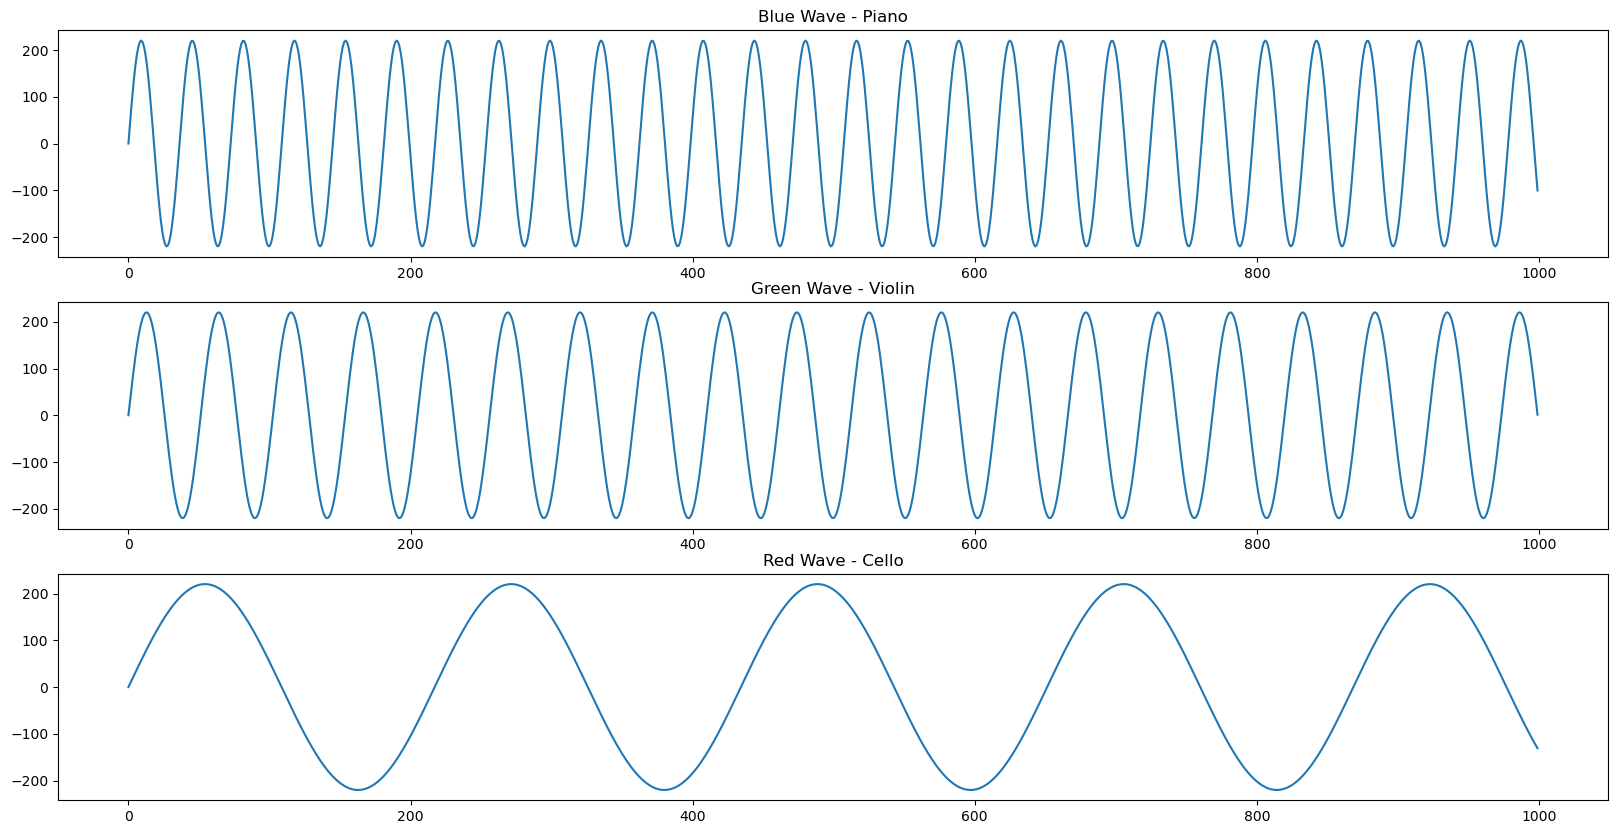

In [97]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.plot(blueWave1[0: 1000])
plt.subplot(3,1,1).set_title("Blue Wave - Piano")

plt.subplot(3,1,2)
plt.plot(greenWave1[0:1000])
plt.subplot(3,1,2).set_title("Green Wave - Violin")

plt.subplot(3,1,3)
plt.plot(redWave1[0:1000])
plt.subplot(3,1,3).set_title("Red Wave - Cello")

#plt.savefig("video-seperate.png")
plt.show()

In [98]:
waves = [blueWave1, greenWave1, redWave1]
maxCols = max(wave.shape[0] for wave in waves)

blueWave1 = np.hstack((blueWave1, np.random.rand(maxCols - blueWave1.shape[0])))
greenWave1 = np.hstack((greenWave1, np.random.rand(maxCols - greenWave1.shape[0])))
redWave1 = np.hstack((redWave1, np.random.rand(maxCols - redWave1.shape[0])))

combinedWave = blueWave1 + greenWave1 + redWave1 

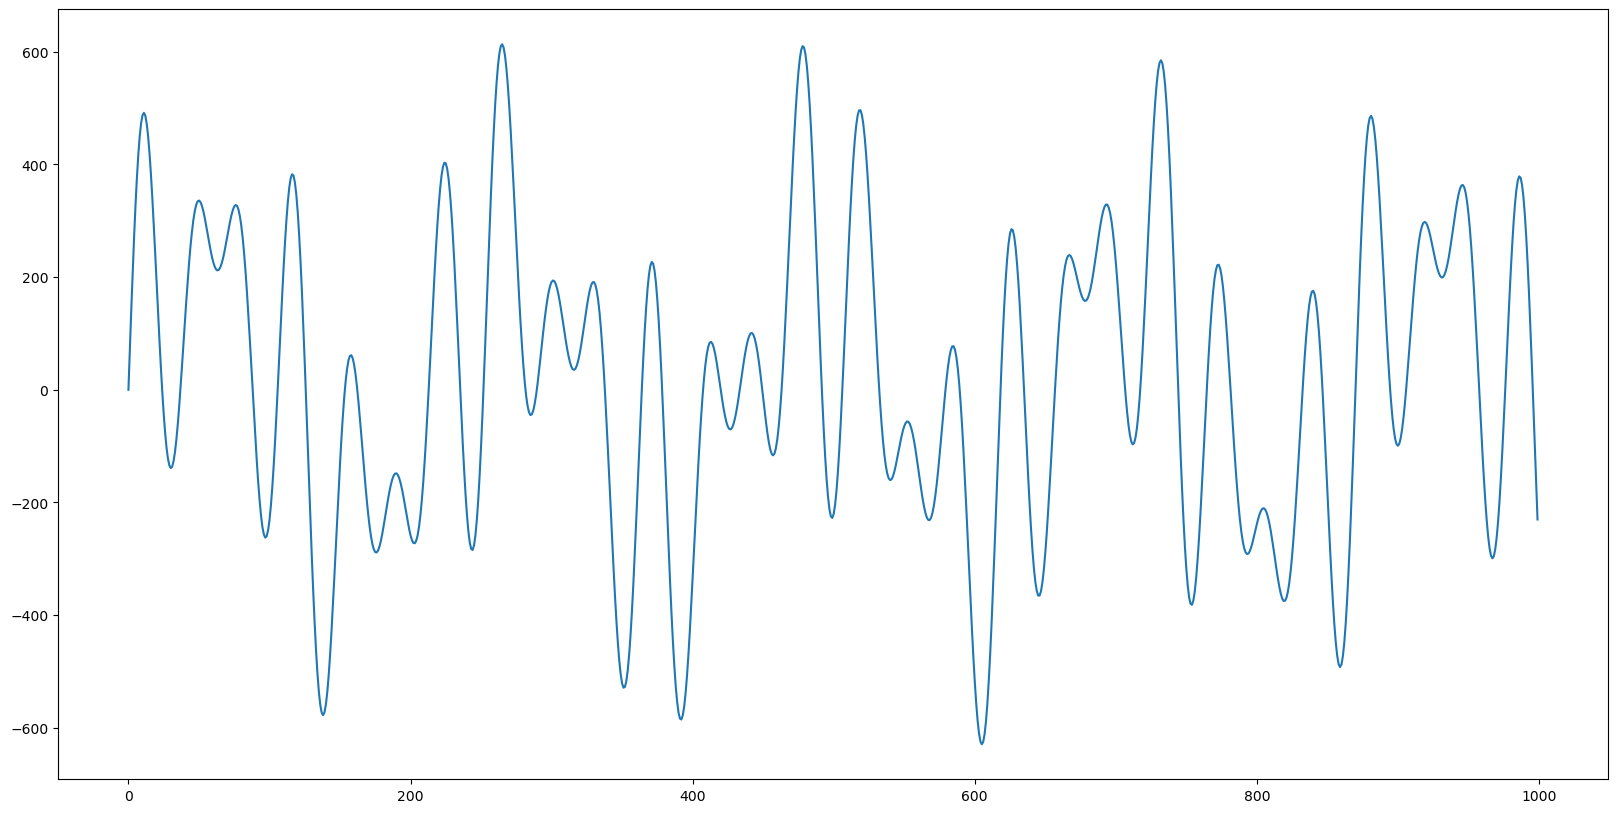

In [99]:
plt.figure(figsize=(20,10))

plt.plot(combinedWave[0:1000])
plt.show()

In [100]:
minCombined = np.min(combinedWave)
maxCombined = np.max(combinedWave)

for i in range(len(combinedWave)):
    combinedWave[i] = (((combinedWave[i] - minCombined)*(2637.0 - 65.4))/(maxCombined-minCombined)) + 65.4

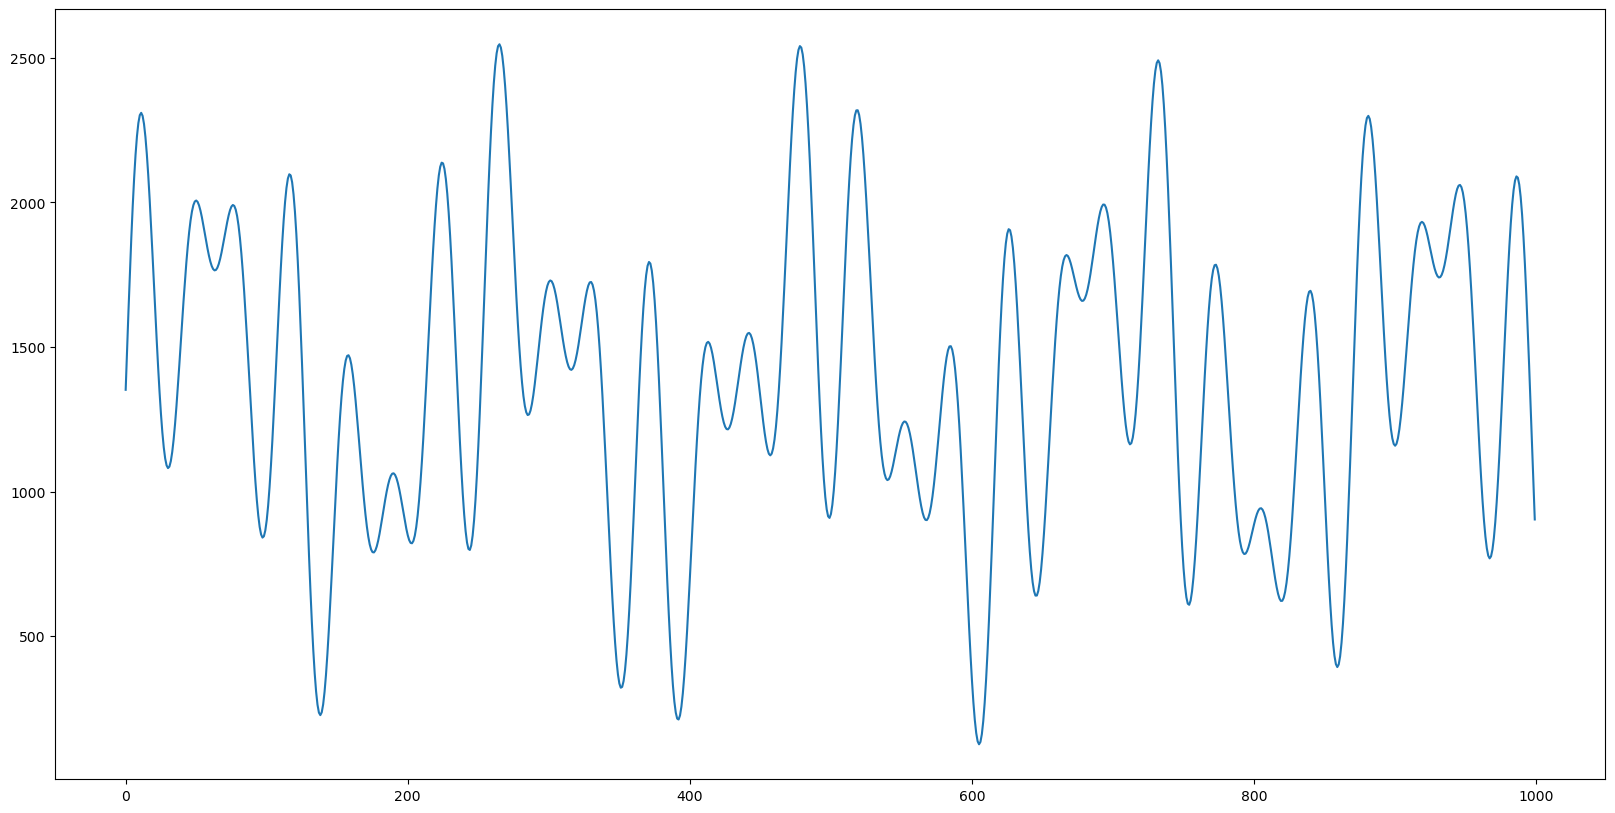

In [101]:
plt.figure(figsize=(20,10))

plt.plot(combinedWave[0:1000])
#plt.savefig("video-combined.png")
plt.show()

In [102]:
wavfile.write('video.mp3', int(SAMPLE_RATE), combinedWave.astype(np.int16))